# Clean up for your vacation images - Deepdive

In [1]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [2]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

import spring_cleaning as sc # outsourced code

# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')
df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]
df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
df['target'] = df['target'] + 1

# How many correlations exist between images?

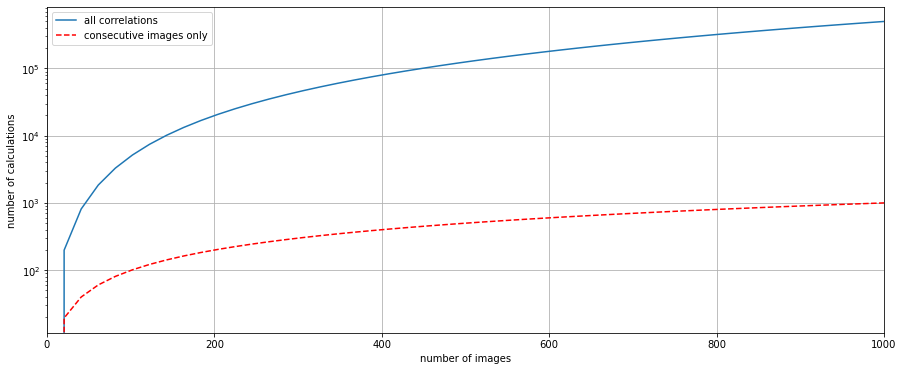

In [3]:
# function increases steeply, thus we make the assumption that only 
# consecutive images are related to each other

def corr(n):
    return n*(n-1)/2

n_max = 1000
n = np.linspace(0, n_max)
plt.figure(figsize=(15, 6))
plt.plot(n, corr(n), label='all correlations')
plt.plot(n, n-1, 'r--', label='consecutive images only')
plt.xlabel('number of images')
plt.ylabel('number of calculations')
plt.grid()
plt.legend()
plt.xlim([0, n_max])
plt.semilogy();

# Deep-dive: Hashing

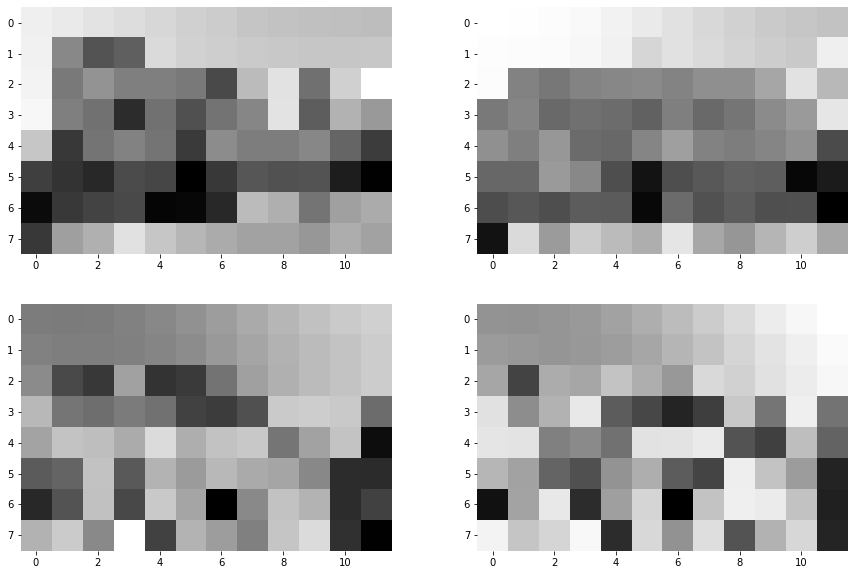

In [4]:
# Hashing refers here to a low-pixel degredation of the image

fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[0]), cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[1]), cmap='gray')
plt.subplot(223, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[2]), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[3]), cmap='gray')

# Find optimal dimensions for hashing of images (8, 8) -> (n, m)

In [5]:
hashings = sc.batch_hashing(df)

In [6]:
similar_hash = sc.return_hashing_dist(hashings, _type='similar', 
                                            target_col='target', comp_col='hash_value')
nonsimilar_hash = sc.return_hashing_dist(hashings, _type='nonsimilar', 
                                           target_col='target', comp_col='hash_value')

mean_hashes_similar = np.array([(8+enum, d.mean()) for enum, d in enumerate(similar_hash)])
mean_hashes_nonsimilar = np.array([(8+enum, d.mean()) for enum, d in enumerate(nonsimilar_hash)])

Similar images mean: 0.870 +- 0.004
Non-similar images mean: 0.662 +- 0.004


(0.875, 0.625)

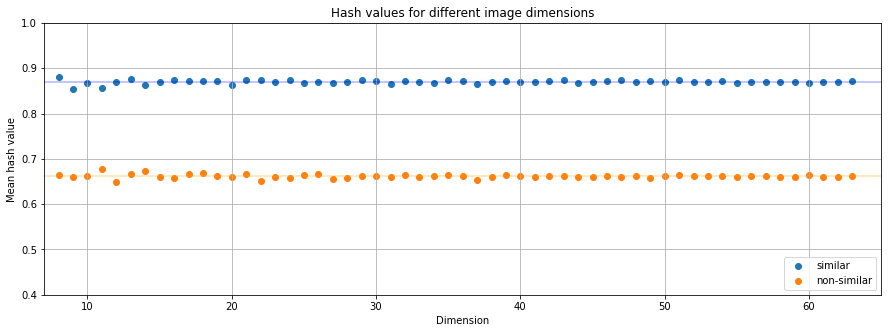

In [7]:
plt.figure(figsize=(15, 5))
plt.scatter(mean_hashes_similar[:,0], mean_hashes_similar[:,1], label='similar')
plt.scatter(mean_hashes_nonsimilar[:,0], mean_hashes_nonsimilar[:,1], label='non-similar')

plt.plot([5,66], [mean_hashes_similar[:,1].mean()]*2, color='blue', alpha=0.3)
plt.plot([5,66], [mean_hashes_nonsimilar[:,1].mean()]*2, color='orange', alpha=0.3)

plt.axis([7, 65, 0.4, 1.0])
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Dimension')
plt.ylabel('Mean hash value')
plt.title('Hash values for different image dimensions')

# mean values seem to be consistent independently of hashing dimension
# it is open, if anisotropic changes yield different results

print('Similar images mean: {:.3f} +- {:.3f}'.format(mean_hashes_similar[:,1].mean(), 
                mean_hashes_similar[:,1].std()))
print('Non-similar images mean: {:.3f} +- {:.3f}'.format(mean_hashes_nonsimilar[:,1].mean(), 
                mean_hashes_nonsimilar[:,1].std()))
56/64, 40/64

# Rotate

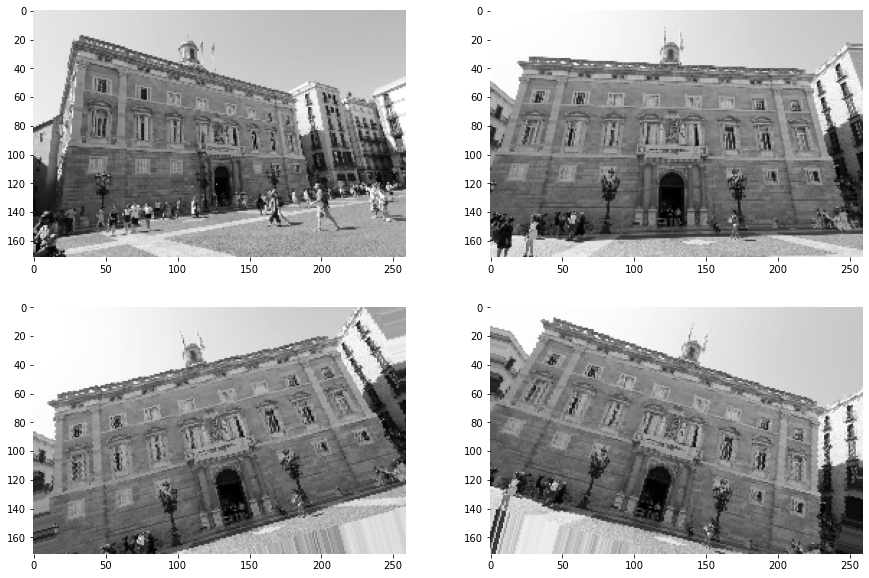

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(df['gray_images'].iloc[0], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(df['gray_images'].iloc[1], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.rotate_img(df['gray_images'].iloc[1], 15), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.rotate_img(df['gray_images'].iloc[1], -15), cmap='gray')

# Warp images

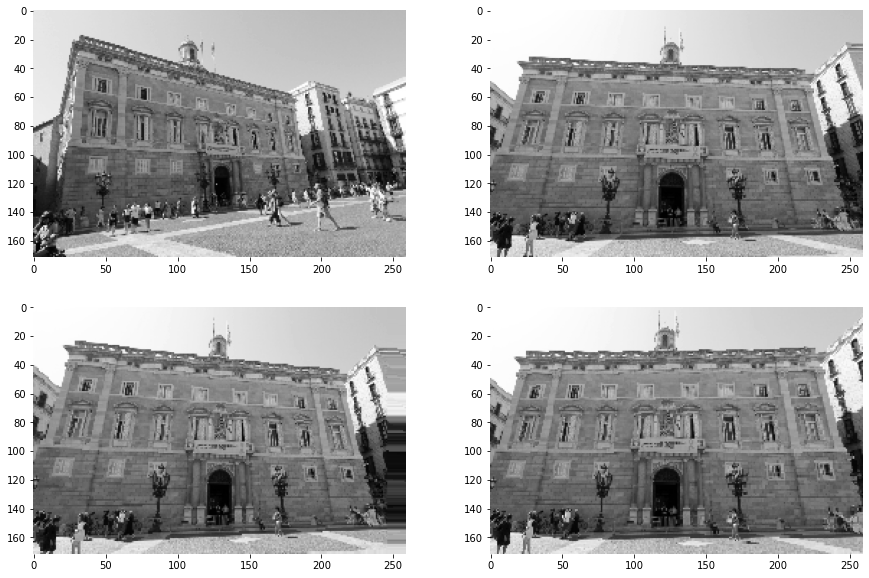

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(df['gray_images'].iloc[0], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(df['gray_images'].iloc[1], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.warp_img(df['gray_images'].iloc[1], 0.05, how='left'), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.warp_img(df['gray_images'].iloc[1], 0.05, how='right'), cmap='gray')